# Optimizing your code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

For mac:
    
    > brew install gcc
    > brew install gfortran
    
    > gcc
    > gfortran

For Debian:
    
    > sudo apt install build-essential
    > gcc
    > gfortran

In [2]:
%conda install numba numexpr cython
# pip version
#%pip install numba numexpr cython


UnavailableInvalidChannel: The channel is not accessible or is invalid.
  channel name: intel
  channel url: https://conda.anaconda.org/intel
  error code: 403

You will need to adjust your conda configuration to proceed.
Use `conda config --show channels` to view your configuration's current state,
and use `conda config --show-sources` to view config file locations.



Note: you may need to restart the kernel to use updated packages.


When your math works, the next step is often to try and make the code faster.
Optimizing is very delicate work as oftentimes we immediately go for more aggressive options. 
As a rule of thumb takes these steps towards optimisation:
   
   1. See if its been done already
   2. Code the math
   3. Simplify
   4. Algorithmic improvement
   5. Use libraries like `numexpr` and `numba`
   6. Parallelize
   7. Rewrite in C++/FORTRAN

## Quick optimization (Caching)

Caching function results is often a quick and easy way to get some performance out of your code. This is best used on functions with a limited range of arguments. Python provides the `lru_cache` decorator from the `functools` package

In [2]:
def compute_a_slow_result(x):
    import time
    
    time.sleep(0.1)
    return x*2



In [3]:
%timeit compute_a_slow_result(10)

102 ms ± 601 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Lets now decorate our function with `lru_cache`

In [4]:
from functools import lru_cache

@lru_cache(maxsize=-1)
def compute_a_slow_result_cache(x):
    import time
    
    time.sleep(0.1)
    return x*2



In [5]:
compute_a_slow_result_cache(10)

20

In [6]:
%timeit compute_a_slow_result_cache(10)

72.3 ns ± 1.93 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In the background `lru_cache` is storing a list of function arguments and return values, when a function with an argument is run for the first time it is run normally and then its return stored. The next time the same arguments are used this will instead simply return the store value! the `maxsize=4` tells `lru_cache` to cache a maximum of 4 function calls.

Our function can be broken if we use a random value each time:

In [9]:
import random
%timeit compute_a_slow_result_cache(random.randint(1,100_000))

102 ms ± 380 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Test Problem

Lets write our own linterpolation algorithm. Whilst numpy and scipy have their own interpolation. Ours will be slightly different.

Mathematically the formula looks like this:

$$
y = \frac{e^{y_0^{2}}(x_1 - x)+y_1(x - x_0)}{x_1 - x_0}
$$

this has no physics behind it other than taking the linear interpolation algorithm and adding a square exp function.

Lets implement and test this function

In [10]:
def linear_interpolate(y0, y1, x0, x1, x):
    
    return (np.exp(y0**2) * (x1 - x) + y1 * (x - x0))  / (x1 - x0)

In [11]:
n = 50_000_000
y0 = np.random.rand(n)
y1 = np.random.rand(n)
%timeit linear_interpolate(y0, y1, 2, 3, 2.5)

1.1 s ± 17.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Numexpr

With numpy we get pretty decent performance. However we can push this a bit further with minimal effort by using the `numexpr` package.

Numexpr can take advantage of threading and inbuilt libraries to get faster performance. It works by compiling a computational string that represent the computation and figuring out how best to split the computation up.

In [12]:
def linear_interpolate_numexpr(y0, y1, x0, x1, x):
    import numexpr as ne
    
    return ne.evaluate('(exp(y0**2) * (x1 - x) + y1 * (x - x0))  / (x1 - x0)')

In [13]:
%timeit linear_interpolate_numexpr(y0, y1, 2, 3, 2.5)

228 ms ± 22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## FORTRAN

The classic programming language. `numpy` actually has the `f2py` module specifically to allow FORTRAN code to be included in Python! We can run it from the command line like this:
    
    python -m numpy.f2py --quiet -c src/interp.f90 -m vect

Where it will create a new python module stated by the last `-m` argument. Lets see it in action!

In [12]:
!ls

Optimizing.ipynb Parallel.ipynb   SymPy.ipynb


In [14]:
import sys
{sys.executable}

{'/Users/ahmed/venv/bin/python'}

In [15]:
import sys
!{sys.executable} -m numpy.f2py --quiet -c ../src/interp.f90 -m vect  --fcompiler=gnu95 --f90flags="-O3 -march=native"

/Users/ahmed/venv/lib/python3.10/site-packages/numpy/f2py/f2py2e.py:718: VisibleDeprecationWarning: 
distutils has been deprecated since NumPy 1.26.x
Use the Meson backend instead, or generate wrappers without -c and use a custom build script
  builder = build_backend(
{}
Removing build directory /var/folders/cr/hx9slfzd61xdy7vghl6l64k80000gn/T/tmpkq0n0b4s


In [16]:
import vect
vect.fort_linear?

Call signature: vect.fort_linear(*args, **kwargs)
Type:           fortran
String form:    <fortran function fort_linear>
Docstring:     
c = fort_linear(y0,y1,x0,x1,x,[n])

Wrapper for ``fort_linear``.

Parameters
----------
y0 : input rank-1 array('d') with bounds (n)
y1 : input rank-1 array('d') with bounds (n)
x0 : input float
x1 : input float
x : input float

Other Parameters
----------------
n : input int, optional
    Default: shape(y0, 0)

Returns
-------
c : rank-1 array('d') with bounds (n)

In [17]:
vect.fort_linear(y0, y1, 2, 3, 2.5)

array([1.12915853, 0.76681518, 0.83544791, ..., 0.83274967, 1.04797274,
       1.10821748])

In [18]:
%timeit vect.fort_linear(y0, y1, 2, 3, 2.5)

540 ms ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Cython

In [19]:
%load_ext cython

In [22]:
%%cython -a
import numpy as np
cimport numpy as np
ctypedef np.float64_t dtype_t
cimport cython
from libc.math cimport exp


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
@cython.cdivision(True)
def linear_cython(double[::1] y0,
                  double[::1] y1, 
                  double x0, double x1, double x):
    cdef Py_ssize_t i
    
    cdef Py_ssize_t y_max = y0.shape[0]
    
    result = np.empty(y0.shape[0], dtype=np.float64)
    
    cdef double[::1] result_view = result
    for i in range(y_max):
        result_view[i] = (exp(y0[i] * y0[i]) * (x1 - x) + y1[i] * (x - x0))  / (x1 - x0)
    return result
        
        
        

Content of stderr:
In file included from /Users/ahmed/.cache/ipython/cython/_cython_magic_d06752518f026245949d52d390afa057806ccf52.c:1250:
In file included from /Users/ahmed/venv/lib/python3.10/site-packages/numpy/_core/include/numpy/arrayobject.h:5:
In file included from /Users/ahmed/venv/lib/python3.10/site-packages/numpy/_core/include/numpy/ndarrayobject.h:12:
In file included from /Users/ahmed/venv/lib/python3.10/site-packages/numpy/_core/include/numpy/ndarraytypes.h:1909:
/Users/ahmed/venv/lib/python3.10/site-packages/numpy/_core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
/Users/ahmed/.cache/ipython/cython/_cython_magic_d06752518f026245949d52d390afa057806ccf52.c:24463:26: warning: code will never be executed [-Wunreachable-code]
                module = PyImport_ImportModuleLevelObject(
   

In [23]:
%timeit linear_cython(y0,y1,2,3,2.5)

566 ms ± 17.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Numba

In [24]:
def linear_interpolate_bad(y0, y1, x0, x1, x):
    out = np.zeros(y0.shape)
    for n in range(y0.shape[0]):
        out[n] = (np.exp(y0[n]**2) * (x1 - x) + y1[n] * (x - x0))  / (x1 - x0)

    return out

In [25]:
%time linear_interpolate_bad(y0, y1, 2, 3, 2.5)

CPU times: user 1min 18s, sys: 331 ms, total: 1min 18s
Wall time: 1min 19s


array([1.12915853, 0.76681518, 0.83544791, ..., 0.83274967, 1.04797274,
       1.10821748])

In [26]:
import numba

@numba.njit
def linear_interpolate_good(y0, y1, x0, x1, x):
    out = np.zeros(y0.shape)
    for n in range(y0.shape[0]):
        out[n] = (np.exp(y0[n]**2) * (x1 - x) + y1[n] * (x - x0))  / (x1 - x0)

    return out

In [27]:
%timeit linear_interpolate_good(y0, y1, 2, 3, 2.5)

585 ms ± 30.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
import numba

@numba.njit(parallel=True, fastmath=True)
def linear_interpolate_best(y0, y1, x0, x1, x):
    out = np.zeros(y0.shape)
    for n in numba.prange(y0.shape[0]):
        out[n] = (np.exp(y0[n]**2) * (x1 - x) + y1[n] * (x - x0))  / (x1 - x0)

    return out

In [29]:
%timeit linear_interpolate_best(y0, y1, 2, 3, 2.5)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


263 ms ± 72.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Go away FORTRAN and C++ shooo shooooo

In [30]:
def mandelbrot_python(size, iterations):
    m = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            c = (-2 + 3. / size * j +
                 1j * (1.5 - 3. / size * i))
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break
    return m

In [31]:
size = 400
iterations = 100

In [32]:
%time mandelbrot_python(size, iterations)

CPU times: user 4.63 s, sys: 25.8 ms, total: 4.66 s
Wall time: 4.71 s


array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])

In [33]:
@numba.njit
def mandelbrot_numba(size, iterations):
    m = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            c = (-2 + 3. / size * j +
                 1j * (1.5 - 3. / size * i))
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break
    return m

In [34]:
%timeit mandelbrot_numba(size, iterations)

20 ms ± 406 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


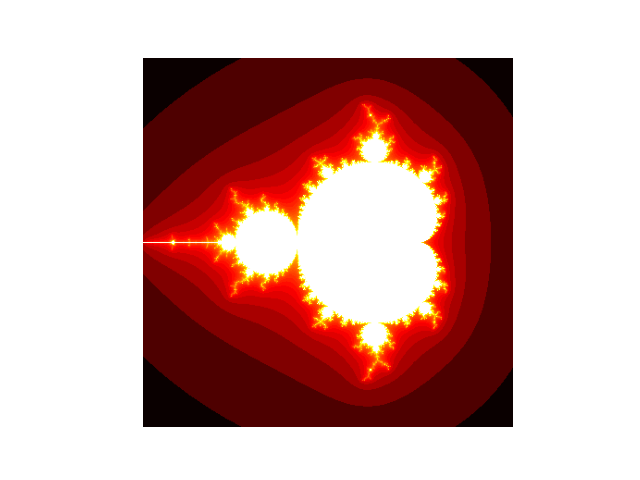

In [36]:
m = mandelbrot_numba(size, iterations)

fig, ax = plt.subplots(1, 1)
ax.imshow(np.log(m), cmap=plt.cm.hot)
ax.set_axis_off()